In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os



import uproot3


rc('text', usetex=True)

import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

#
mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})
mpl.rcParams.update({'axes.labelsize': 18}) 
mpl.rcParams.update({'legend.frameon': False}) 

#import mplhep as hep
#hep.set_style(hep.style.ROOT)

/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/uproot3/__init__.py:138: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  FutureWarning
/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/awkward0/__init__.py:23: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  FutureWarning


In [2]:
#
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
#sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [3]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

In [4]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print (text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut))
    return cutDataframe

In [5]:
def applyCutsJets(df,isMC=False):
    temp = df
    #temp = applyCut(temp, 'abs(vertex_z)<25 and vertex_z!=0','abs(vertex_z)<25 and and vertex_z!=0')
    #temp = applyCut(temp, 'tau1b>0 and tau1b<1', '0<tau1b<1')
    temp.eval('jet_px = jet_pt*cos(jet_phi)', inplace=True)
    temp.eval('jet_py = jet_pt*sin(jet_phi)', inplace=True)
    temp.eval('jet_qt = sqrt( (jet_px + e_px)**2 + (jet_py + e_py)**2) ', inplace=True)
    temp.eval('jet_qtnorm = jet_qt/sqrt(Q2)', inplace=True)
    temp.eval('e_pt = sqrt(e_px*e_px + e_py*e_py)',inplace=True)

    temp.eval('logQ2= log(Q2)/2.3025850', inplace=True)

    temp = applyCut(temp, '0.2 < y < 0.7', '0.2 < y < 0.7')
    temp = applyCut(temp, 'Q2>150', 'Q2>150')
    temp = applyCut(temp, 'pass_reco==0 | jet_pt>5.0', 'jet pT > 5 GeV')


    if(isMC):
        temp.eval('gen_logQ2= log(gen_Q2)/2.3025850', inplace=True)   
        temp.eval('gene_pt = sqrt(gene_px*gene_px + gene_py*gene_py)',inplace=True)
        temp.eval('genjet_px = genjet_pt*cos(genjet_phi)', inplace=True)
        temp.eval('genjet_py = genjet_pt*sin(genjet_phi)', inplace=True)
        temp.eval('genjet_qt = sqrt( (genjet_px + gene_px)**2 + (genjet_py + gene_py)**2) ', inplace=True)
        temp.eval('genjet_qtnorm = genjet_qt/sqrt(gen_Q2)', inplace=True)
        
        
    #    temp.eval('genjet_qtnormept= genjet_qt/e_pt', inplace=True)
    #    temp.eval('genjet_qtnormjetpt= genjet_qt/genjet_pt', inplace=True)


    #df = applyCut(df, 'n_total>1', ' n>1')
    return temp

## Get dataframes, apply selection

In [6]:
path = '/home/miguel/HERA/out_em0405/'
dataname = path+'data.root'
mcname = path+'Django.root'
altmcname = path+'Rapgap.root'

In [7]:
datatree = uproot3.open(dataname)['Data/minitree']
mctree   = uproot3.open(mcname)['Django/minitree']
altmctree  = uproot3.open(altmcname)['Rapgap/minitree']

In [8]:
data =  datatree.pandas.df(["jet*","Q2","y","e_*"], entrystop=3e5,flatten=True)   # not the default

In [9]:
mc =  mctree.pandas.df(["jet*", "genjet*","Q2","gen_Q2","y",'gen_y',"e_*","gene*"], entrystop=3e5,flatten=True)   # not the default

In [10]:
altmc =  altmctree.pandas.df(["jet*", "genjet*","Q2","gen_Q2","y","gen_y","e_*","gene*"], entrystop=3e5,flatten=True)   # not the default

In [11]:
mc.keys()

Index(['jet_pt', 'jet_phi', 'jet_eta', 'jet_dphi', 'genjet_pt', 'genjet_phi',
       'genjet_eta', 'Q2', 'gen_Q2', 'y', 'gen_y', 'e_px', 'e_py', 'e_pz',
       'gene_px', 'gene_py', 'gene_pz'],
      dtype='object')

## Defining pass reco and pass truth variables

In [12]:
mc['pass_reco'] = np.where(mc['jet_pt']>0, 1, 0)
mc['pass_truth'] = np.where(mc['jet_pt']>0, 1, 0)
altmc['pass_reco'] = np.where(altmc['jet_pt']>0, 1, 0)
altmc['pass_truth'] = np.where(altmc['jet_pt']>0, 1, 0)
data['pass_reco'] = np.where(data['jet_pt']>0, 1, 0)

## Event selection

In [13]:
print('Selecting data events\n')
data = applyCutsJets(data)
print('Selecting MC events\n')
mc   = applyCutsJets(mc, isMC=True)
print('alt mc')
altmc = applyCutsJets(altmc, isMC=True)

Selecting data events

0.2 < y < 0.7 126239  fraction kept: 53.6
Q2>150 105569  fraction kept: 83.6
jet pT > 5 GeV 105569  fraction kept: 100.0
Selecting MC events

0.2 < y < 0.7 222043  fraction kept: 69.6
Q2>150 190202  fraction kept: 85.7
jet pT > 5 GeV 190202  fraction kept: 100.0
alt mc
0.2 < y < 0.7 213671  fraction kept: 69.0
Q2>150 187438  fraction kept: 87.7
jet pT > 5 GeV 187438  fraction kept: 100.0


In [14]:
mc.head()

jet_pt   jet_phi   jet_eta  jet_dphi  genjet_pt  \
entry subentry                                                       
0     0         17.821012  4.272156 -0.132420       0.0  18.245798   
2     0         19.339769  1.657020 -0.498900       0.0  18.930017   
4     0         14.035999  0.785462  0.309769       0.0  14.487093   
5     0         17.071587  4.747540  0.296118       0.0  18.760893   
      1         10.083800  3.029718  2.238095       0.0  11.687999   

                genjet_phi  genjet_eta          Q2      gen_Q2         y  ...  \
entry subentry                                                            ...   
0     0           4.247417   -0.101553  503.772125  493.079468  0.386226  ...   
2     0           1.676580   -0.514370  842.442139  878.726135  0.655872  ...   
4     0           0.795348    0.279637  368.373474  352.494873  0.223028  ...   
5     0           4.719078    0.225322  745.689453  726.796326  0.365576  ...   
      1           3.027058    2.183209  745.689453  726.796326  0.365576  ...   

                   jet_qt  jet_qtnorm       e_pt     logQ2  gen_logQ2  \
entry subentry                                                          
0     0          0.190240    0.008476  17.631079  2.702235   2.692917   
2     0          2.264769    0.078029  17.146223  2.925540   2.943854   
4     0          2.946217    0.153504  16.801741  2.566288   2.547153   
5     0         12.610858    0.461812  21.594707  2.872558   2.861413   
      1         19.193962    0.702887  21.594707  2.872558   2.861413   

                  gene_pt  genjet_px  genjet_py  genjet_qt  genjet_qtnorm  
entry subentry                                                             
0     0         17.102211  -8.181376 -16.308718   1.224973       0.055166  
2     0         17.760504  -1.998747  18.824202   1.494112       0.050403  
4     0         16.473866  10.141495  10.345334   2.160768       0.115088  
5     0         21.004848   0.125492 -18.760473  11.833632       0.438947  
      1         21.004848 -11.611420   1.335757  18.820978       0.698129  

[5 rows x 31 columns]

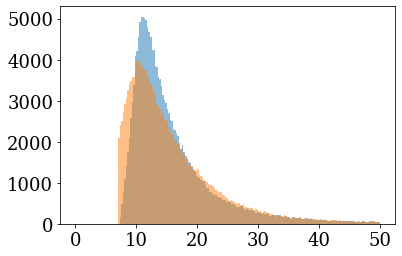

In [15]:
plt.hist(mc.query('pass_reco==1')['e_pt'],range=(0,50),bins=200,alpha=0.5)
plt.hist(mc.query('pass_reco==1')['jet_pt'],range=(0,50),bins=200,alpha=0.5)

plt.show()

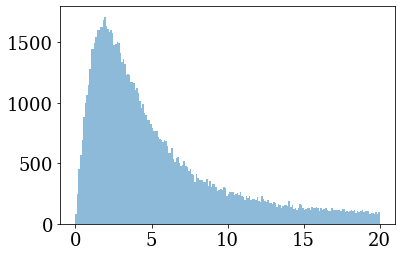

In [16]:
plt.hist(data['jet_qt'],range=(0,20), bins=200,alpha=0.5)
plt.show()

In [17]:
mc_cut = mc#[:100000]
altmc_cut = altmc#[:100000]

In [18]:
print(len(data))
print(len(mc_cut.query('pass_reco==1'))) ##only what is really reconstructed counts
print(len(mc_cut)) ##only what is really reconstructed counts
print(len(altmc_cut.query('pass_reco==1'))) ##only what is really reconstructed counts


105569
179110
190202
175804


### Define UniFold Algorithm


In [19]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Dense, Input
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

## Define features using just MC and alt MC *this is CLOSURE TEST*

In [20]:
epx_0_G       = mc_cut['gene_px']
epx_0_S       = mc_cut['e_px']
epx_unknown_G = altmc_cut['gene_px']
epx_unknown_S = altmc_cut['e_px']

epy_0_G       = mc_cut['gene_py']
epy_0_S       = mc_cut['e_py']
epy_unknown_G = altmc_cut['gene_py']
epy_unknown_S = altmc_cut['e_py']

epz_0_G       = mc_cut['gene_pz']
epz_0_S       = mc_cut['e_pz']
epz_unknown_G = altmc_cut['gene_pz']
epz_unknown_S = altmc_cut['e_pz']


jetpt_0_G       = mc_cut['genjet_pt']
jetpt_0_S       = mc_cut['jet_pt']
jetpt_unknown_G = altmc_cut['genjet_pt']
jetpt_unknown_S = altmc_cut['jet_pt']


jetphi_0_G       = mc_cut['genjet_phi']
jetphi_0_S       = mc_cut['jet_phi']
jetphi_unknown_G = altmc_cut['genjet_phi']
jetphi_unknown_S = altmc_cut['jet_phi']


jeteta_0_G       = mc_cut['genjet_eta']
jeteta_0_S       = mc_cut['jet_eta']
jeteta_unknown_G = altmc_cut['genjet_eta']
jeteta_unknown_S = altmc_cut['jet_eta']




In [21]:
theta0_G=np.c_[(epx_0_G, epy_0_G, epz_0_G,  jetpt_0_G, jeteta_0_G, jetphi_0_G)]
theta0_S=np.c_[(epx_0_S, epy_0_S, epz_0_S,  jetpt_0_S, jeteta_0_S, jetphi_0_S)]
theta_unknown_G =np.c_[(epx_unknown_G, epy_unknown_G, epz_unknown_G, jetpt_unknown_G, jeteta_unknown_G, jetphi_unknown_G)]
theta_unknown_S =np.c_[(epx_unknown_S, epy_unknown_S, epz_unknown_S, jetpt_unknown_S, jeteta_unknown_S, jetphi_unknown_S)]


In [22]:
pass_reco = np.array(mc_cut['pass_reco'])
pass_truth = np.array(mc_cut['pass_truth'])
theta0_S[:,0][pass_reco==0] = -10
theta0_G[:,0][pass_truth==0] = -10

## Show input for closure test (i.e. synthetic and natural datasets using mc and altmc)

/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


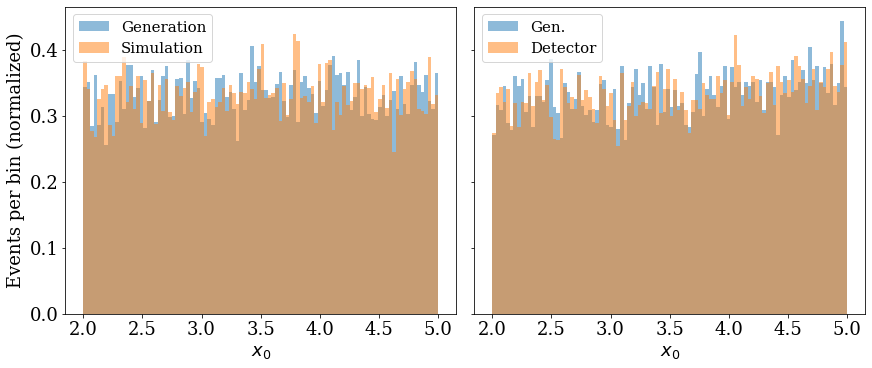

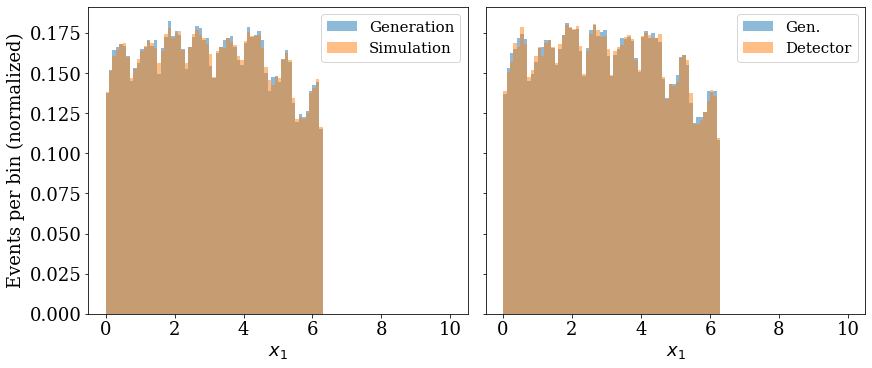

In [23]:
bins = np.linspace(2,5, 101)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x_0$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G[theta0_G[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(
    loc='best',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x_0$')

ax[1].hist(theta_unknown_G[theta_unknown_S[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Gen.')
legend = ax[1].legend(
    loc='best',
    frameon=True)


ax[1].hist(theta_unknown_S[theta_unknown_S[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Detector')
legend = ax[1].legend(
    loc='best',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

bins = np.linspace(0,10, 101)
#bins = np.linspace(0,2, 101)
#bins = np.linspace(0,1,100)
fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G[theta0_G[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(
    loc='best',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x_1$')

ax[1].hist(theta_unknown_G[theta_unknown_S[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Gen.')
legend = ax[1].legend(
    loc='best',
    frameon=True)

ax[1].hist(theta_unknown_S[theta_unknown_S[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Detector')
legend = ax[1].legend(
    loc='best',
    frameon=True)






plt.setp(legend.get_title(), multialignment='center')

fig.show()

## Define Multifold 

In [24]:
# Input multiple observables as tuple or list (i.e. theta0_G = (obs_1, obs_2, ...))
"""    Arguments:
        num_observables: number of observables to 
                            simultaneously unfold (integer)
                            
        iterations: number of iterations (integer)
        
        theta0_G: tuple or list of nominal 
                    generation-level observables as Numpy arrays
                    
        theta0_S: tuple or list of nominal 
                    simulation-level observables as Numpy arrays
                    
        theta_unknown_S: tuple or list of "natural" 
                            (unknown) simulation-level observables 
                            to be unfolded as Numpy arrays
        
        Returns:
        - A Numpy array of weights to reweight distributions in 
        theta0_G to the unfolded distribution of theta_unknown_S
        
        - The model used to calculate those weights
"""


def multifold(num_observables, iterations, theta0_G, theta0_S,
              theta_unknown_S):
    
    
    theta0 = np.stack([theta0_G, theta0_S], axis=1)
    labels0 = np.zeros(len(theta0))
    theta_unknown = np.stack([theta_unknown_S, theta_unknown_S], axis=1)
    labels1 = np.ones(len(theta0_G))
    labels_unknown = np.ones(len(theta_unknown_S))
    
    xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels0, labels_unknown))
    xvals_2 = np.concatenate((theta0_G, theta0_G))
    yvals_2 = np.concatenate((labels0, labels1))
    

    weights = np.empty(shape=(iterations, 2, len(theta0_G))) #this was 0
    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_S))

    inputs = Input((num_observables, ))
     #inputs = Input((2, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

    model = Model(inputs=inputs, outputs=outputs)

    earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              restore_best_weights=True)
    # from NN (DCTR) 
    def reweight(events):
        f = model.predict(events, batch_size=10000)
        weights = f / (1. - f)
        return np.squeeze(np.nan_to_num(weights))
    
    
    
    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
        # weights reweighted Sim. --> Data
        print("STEP 1\n")

        weights_1 = np.concatenate((weights_push, np.ones(len(theta_unknown_S))))
        # actual weights for Sim., ones for Data (not MC weights)

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        #theta0_G[theta0_S[:,0]!=-10][:,1]
        model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
        model.fit(X_train_1[X_train_1[:,0]!=-10],
              Y_train_1[X_train_1[:,0]!=-10],
              sample_weight=w_train_1[X_train_1[:,0]!=-10],
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_1[X_test_1[:,0]!=-10], Y_test_1[X_test_1[:,0]!=-10], w_test_1[X_test_1[:,0]!=-10]),
              callbacks=[earlystopping],
              verbose=1)

        weights_pull = weights_push * reweight(theta0_S)
        weights_pull[theta0_S[:,0]==-10] = 1. #these are events that don't pass reco; take the prior.
        weights[i, :1, :] = weights_pull

        # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
        # weights Gen. --> reweighted Gen.
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
        # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
        model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=1)

        weights_push = reweight(theta0_G)
        weights[i, 1:2, :] = weights_push
    return weights, model

## Unfold two variables simultaneously

In [25]:
K.clear_session()

In [ ]:
iterations = 4# use ~4 iterations
num_observables= 6

weights, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=theta0_G,
                       theta0_S=theta0_S,
                       theta_unknown_S= theta_unknown_S)


ITERATION: 1

STEP 1

Epoch 1/200
28/28 [==============================] - 5s 183ms/step - loss: 7.9342 - accuracy: 0.5090 - val_loss: 0.6801 - val_accuracy: 0.5164
Epoch 2/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6757 - accuracy: 0.5204 - val_loss: 0.6732 - val_accuracy: 0.5227
Epoch 3/200
28/28 [==============================] - 0s 3ms/step - loss: 0.6722 - accuracy: 0.5266 - val_loss: 0.6717 - val_accuracy: 0.5287
Epoch 4/200
28/28 [==============================] - 0s 3ms/step - loss: 0.6711 - accuracy: 0.5320 - val_loss: 0.6707 - val_accuracy: 0.5315
Epoch 5/200
28/28 [==============================] - 0s 3ms/step - loss: 0.6706 - accuracy: 0.5351 - val_loss: 0.6706 - val_accuracy: 0.5317
Epoch 6/200
28/28 [==============================] - 0s 3ms/step - loss: 0.6703 - accuracy: 0.5366 - val_loss: 0.6702 - val_accuracy: 0.5366
Epoch 7/200
28/28 [==============================] - 0s 3ms/step - loss: 0.6700 - accuracy: 0.5382 - val_loss: 0.6699 - val_accur

/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide


Epoch 1/200
29/29 [==============================] - 5s 188ms/step - loss: 0.6909 - accuracy: 0.4997 - val_loss: 0.6895 - val_accuracy: 0.4996
Epoch 2/200
29/29 [==============================] - 0s 4ms/step - loss: 0.6893 - accuracy: 0.4998 - val_loss: 0.6899 - val_accuracy: 0.4983
Epoch 3/200
29/29 [==============================] - 0s 4ms/step - loss: 0.6891 - accuracy: 0.4994 - val_loss: 0.6901 - val_accuracy: 0.4979
Epoch 4/200
29/29 [==============================] - 0s 4ms/step - loss: 0.6894 - accuracy: 0.4996 - val_loss: 0.6919 - val_accuracy: 0.4966
Epoch 5/200
29/29 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.4999 - val_loss: 0.6906 - val_accuracy: 0.4983
Epoch 6/200
29/29 [==============================] - 0s 4ms/step - loss: 0.6896 - accuracy: 0.5002 - val_loss: 0.6901 - val_accuracy: 0.4976
Epoch 7/200
29/29 [==============================] - 0s 4ms/step - loss: 0.6894 - accuracy: 0.4997 - val_loss: 0.6904 - val_accuracy: 0.4976
Epoch 8/200

## Put weights into MC dataframe

In [ ]:
mc_cut['weight_reco'] = weights[-1, 0, :]
mc_cut['weight_truth'] = weights[-1, 1, :]

## Check that weights are reasonable

In [ ]:
plt.hist(np.log(mc_cut['weight_truth']),bins=100,**plot_style_2,label='Weight truth')
plt.hist(np.log(mc_cut['weight_reco']),bins=100,**plot_style_2, label='Weight reco')
plt.legend()
plt.xlabel('Log 10 weight truth')
plt.yscale('log')
plt.show()

for i in range(len(weights)):
    print(max(weights[i, 1, :]))
    print(min(weights[i, 1, :]))
    print(max(weights[i, 0, :]))
    print(min(weights[i, 0, :]))
    print(' ')

## Closure Test

In [ ]:
event_selection = 'gen_y>0.2 and gen_y<0.7 and gen_Q2>150'
#track_selection = 'gen_track_pt>0.2'
jet_selection    = 'genjet_pt>10'
query = 'pass_reco==1 and ' + event_selection + ' and ' + jet_selection
print('The query is:' , query)

label1 = r'Django truth'
label2 = r'Rapgap unfold.'
label3 = r'Rapgap truth'


for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    #bins = np.linspace(5, 50, 45)

    fig, ax = plt.subplots(2,
                           4,
                           figsize=(20, 10),
                           constrained_layout=True)
    bins = np.linspace(0.0, 1.0,40 )

    ax[0,0].set_xlabel(r'$y$',fontsize=22)
    ax[0,0].set_ylabel('Events per bin (Normalized)')
    ax[0,0].hist(mc_cut.query(query)['gen_y'], bins=bins, label=label1, **plot_style_2)
    ax[0,0].hist(mc_cut.query(query)['gen_y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,0].hist(altmc_cut.query(query)['gen_y'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[0,0].legend(frameon=False)

    bins = np.linspace(2, 5,50 )

    ax[0,1].set_xlabel(r'$\log Q^{2}$',fontsize=22)
    ax[0,1].set_ylabel('Events per bin (Normalized)')
    ax[0,1].hist(mc_cut.query(query)['gen_logQ2'], bins=bins, label=label1, **plot_style_2)
    ax[0,1].hist(mc_cut.query(query)['gen_logQ2'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,1].hist(altmc_cut.query(query)['gen_logQ2'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[0,1].legend(frameon=False)

    

    bins = np.linspace(0,50,50 )

    ax[0,2].set_xlabel(r'$jet p_{T} $',fontsize=22)
    ax[0,2].set_ylabel('Events per bin (Normalized)')
    ax[0,2].hist(mc_cut.query(query)['genjet_pt'], bins=bins, label=label1, **plot_style_2)
    ax[0,2].hist(mc_cut.query(query)['genjet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,2].hist(altmc_cut.query(query)['genjet_pt'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[0,2].legend(frameon=False)


    bins = np.linspace(-1.5,3,25 )

    ax[0,3].set_xlabel(r'$jet eta $',fontsize=22)
    ax[0,3].set_ylabel('Events per bin (Normalized)')
    ax[0,3].hist(mc_cut.query(query)['genjet_eta'], bins=bins, label=label1, **plot_style_2)
    ax[0,3].hist(mc_cut.query(query)['genjet_eta'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,3].hist(altmc_cut.query(query)['genjet_eta'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[0,3].legend(frameon=False)

    bins = np.linspace(0,100,25)

    ax[1,0].set_xlabel(r'electron $p_{T}$',fontsize=22)
    ax[1,0].set_ylabel('Events per bin (Normalized)')
    ax[1,0].hist(mc_cut.query(query)['gene_pt'], bins=bins, label=label1, **plot_style_2)
    ax[1,0].hist(mc_cut.query(query)['gene_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[1,0].hist(altmc_cut.query(query)['gene_pt'],
               bins=bins,
               label=label3,
               **plot_style_2)
    ax[1,0].legend(frameon=False,loc='best')
    
    
    
    bins = np.linspace(0,2.5,20)

    ax[1,1].set_xlabel(r'jet $q_{T}/Q$',fontsize=22)
    ax[1,1].set_ylabel('Events per bin (Normalized)')
    ax[1,1].hist(mc_cut.query(query)['genjet_qtnorm'], bins=bins, label=label1, **plot_style_2)
    ax[1,1].hist(mc_cut.query(query)['genjet_qtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[1,1].hist(altmc_cut.query(query)['genjet_qtnorm'],
               bins=bins,
               label=label3,
               **plot_style_2)
    ax[1,1].legend(frameon=False,loc='best')
    
    
    
    bins = np.linspace(0,np.pi,25)

    ax[1,2].set_xlabel(r'jet $\phi$',fontsize=22)
    ax[1,2].set_ylabel('Events per bin (Normalized)')
    ax[1,2].hist(mc_cut.query(query)['genjet_phi'], bins=bins, label=label1, **plot_style_2)
    ax[1,2].hist(mc_cut.query(query)['genjet_phi'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[1,2].hist(altmc_cut.query(query)['genjet_phi'],
               bins=bins,
               label=label3,
               **plot_style_2)
    ax[1,2].legend(frameon=False,loc='best')
    


    #fig.savefig('figures/Closure_HadronInJet_%i_iter.png'%i)    

## Show the reweighting of the reco

In [ ]:
query = 'pass_reco==1 '
print('The query is:' , query)
label1 = r'Django reco'
label2 = r'Django wgt.'
label3 = r'Rapgap reco'

color1='blueviolet'
color2='limegreen'
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    fig, ax = plt.subplots(2,
                           4,
                           figsize=(20, 10),
                           constrained_layout=True)
    bins = np.linspace(0.0, 1.0,40 )

    ax[0,0].set_xlabel(r'$y$',fontsize=22)
    ax[0,0].set_ylabel('Events per bin (Normalized)')
    ax[0,0].hist(mc_cut.query(query)['y'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0,0].hist(mc_cut.query(query)['y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0,0].hist(altmc_cut.query(query)['y'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[0,0].legend(frameon=False,loc='best')

    bins = np.linspace(2, 4,25 )

    ax[0,1].set_xlabel(r'$\log Q^{2}$',fontsize=22)
    ax[0,1].set_ylabel('Events per bin (Normalized)')
    ax[0,1].hist(mc_cut.query(query)['logQ2'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0,1].hist(mc_cut.query(query)['logQ2'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0,1].hist(altmc_cut.query(query)['logQ2'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[0,1].legend(frameon=False,loc='best')

    
    bins = np.linspace(0,50,50 )

    ax[0,2].set_xlabel(r'$ jet p_{T} $',fontsize=22)
    ax[0,2].set_ylabel('Events per bin (Normalized)')
    ax[0,2].hist(mc_cut.query(query)['jet_pt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0,2].hist(mc_cut.query(query)['jet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0,2].hist(altmc_cut.query(query)['jet_pt'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    ax[0,2].set_yscale('log')
    #ax[0,2].set_xscale('log')
    ax[0,2].legend(frameon=False,loc='best')

    
    bins = np.linspace(-1.5,3,25 )

    ax[0,3].set_xlabel(r'$jet \eta $',fontsize=22)
    ax[0,3].set_ylabel('Events per bin (Normalized)')
    ax[0,3].hist(mc_cut.query(query)['jet_eta'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0,3].hist(mc_cut.query(query)['jet_eta'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0,3].hist(altmc_cut.query(query)['jet_eta'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    ax[0,3].legend(frameon=False,loc='best')
    

    bins = np.linspace(0,2.5,20)
    
    ax[1,0].set_xlabel(r'$jet q_{T}/Q $',fontsize=22)
    ax[1,0].set_ylabel('Events per bin (Normalized)')
    ax[1,0].hist(mc_cut.query(query)['jet_qtnorm'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[1,0].hist(mc_cut.query(query)['jet_qtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[1,0].hist(altmc_cut.query(query)['jet_qtnorm'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[1,0].legend(frameon=False,loc='best')
    ax[1,0].set_yscale('log')

   
    bins = np.linspace(0,100,25)

    ax[1,1].set_xlabel(r'$electron p_{T} $',fontsize=22)
    ax[1,1].set_ylabel('Events per bin (Normalized)')
    ax[1,1].hist(mc_cut.query(query)['e_pt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[1,1].hist(mc_cut.query(query)['e_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[1,1].hist(altmc_cut.query(query)['e_pt'],
               bins=bins,
               label=label3,
               **plot_style_2, color=color2)
    
    ax[1,1].legend(frameon=False,loc='best')
    
    #plt.tight_layout()
    #fig.savefig('figures/Closure_3_HadronInJet_%i_iter.png'%i)  
    
    

## Closure for differential plots

In [ ]:
#bins = np.logspace(np.log10(0.01),np.log10(3),8)
bins = np.linspace(0,3,10)

fig, axs = plt.subplots(1, 3,sharey=True, figsize=(20,6), gridspec_kw={'wspace':0, 'hspace':0})

for counter,edges in enumerate([(150,500), (500,1000),(1000,10000)]):
    cut = ' gen_Q2 > %2.2f and gen_Q2 <%2.2f and gen_y>0.2 and gen_y<0.7'%(edges[0],edges[1])
    cut = cut + ' and genjet_pt>10'
    #cut = cut + ' and pass_reco==1'
    print (cut)
    #df_cut = df.query(cut)
    #printSummary(df_cut)
    print ('###########')
    axs[counter].xaxis.set_label_text('jet $q_{T}$', fontsize=25)
    axs[counter].xaxis.set_label_text('jet $q_{T}$', fontsize=25)

    ##Plot data
    #Nelectrons = df.query(cut).shape[0]
   # axs[counter].hist(mc_cut.query(cut+'and pass_reco==1')['track_jt'],weights=mc_cut.query(cut+'and pass_reco==1')['weight_reco'],bins=bins,alpha=0.9,density=True, 
   #                  label='MC wgt to data reco',color='blue',lw=3,histtype='step')

    #axs[counter].hist(mc_cut.query(cut+'and pass_reco==1')['gen_track_jt'],bins=bins,weights=mc_cut.query(cut+'and pass_reco==1')['weight_truth'],label = 'Unfolded',**plot_style_2)
    axs[counter].hist(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,label='Djangoh Truth',**plot_style_2)
    axs[counter].hist(altmc_cut.query(cut)['genjet_qtnorm'],bins=bins,label='Rapgap Truth',**plot_style_2)
    axs[counter].hist(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Rapgap unfold',**plot_style_1)

    axs[counter].legend(prop={'size': 18}, frameon=False, loc='best')
    axs[counter].set_title(' $ %2.0f< Q^{2} < %2.0f$'%(edges[0],edges[1]))


    #axs[counter].text(1.5,2.9,  r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(data_cut.query(cut)['x'].mean(), data_cut.query(cut)['Q2'].mean()), fontsize=18)
    #axs[counter].set_yscale('log')
    #axs[counter].set_xscale('log')

 
axs[0].yaxis.set_label_text('Normalized entries', fontsize=25)


In [ ]:
cut = ' gen_Q2 > %2.2f and gen_Q2 <%2.2f and gen_y>0.2 and gen_y<0.7'%(edges[0],edges[1])
cut = cut + ' and genjet_pt>5'
bins = np.logspace(np.log10(5),np.log10(150),6)
plt.hist(mc_cut.query(cut)['genjet_pt'],bins=bins,label='Djangoh Truth',**plot_style_2)
plt.hist(altmc_cut.query(cut)['genjet_pt'],bins=bins,label='Rapgap Truth',**plot_style_2)
plt.hist(mc_cut.query(cut)['genjet_pt'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Rapgap unfold',**plot_style_1)

plt.legend()
#plt.yscale('log')
plt.show()

In [ ]:
cut = ' gen_Q2 > %2.2f and gen_Q2 <%2.2f and gen_y>0.2 and gen_y<0.7'%(edges[0],edges[1])
cut = cut + ' and genjet_pt>10'
plt.hist(mc_cut.query(cut)['genjet_pt'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Rapgap unfold',**plot_style_1)
plt.hist(mc_cut.query(cut + ' and pass_reco==1')['genjet_pt'],bins=bins,weights=mc_cut.query(cut + ' and pass_reco==1')['weight_truth'],label = 'Rapgap unfold',**plot_style_1)


## check weights

In [ ]:
plt.hist(np.log(mc_cut['weight_truth']),bins=100,**plot_style_2,label='Weight truth')
plt.hist(np.log(mc_cut['weight_reco']),bins=100,**plot_style_2, label='Weight reco')
plt.legend()
plt.xlabel('Log 10 weight truth')
plt.yscale('log')
plt.show()

for i in range(len(weights)):
    print(max(weights[i, 1, :]))
    print(min(weights[i, 1, :]))
    print(max(weights[i, 0, :]))
    print(min(weights[i, 0, :]))
    print(' ')

## Compute some efficiency

In [ ]:
bins = np.logspace(np.log10(5),np.log10(100),20)
num,x,_  = plt.hist(mc_cut.query('pass_reco==1')['genjet_pt'], weights=mc_cut.query('pass_reco==1')['weight_truth'],bins=bins,label='numerator, weighted',alpha=0.3)
den,x,_  = plt.hist(mc_cut['genjet_pt'], weights=mc_cut['weight_truth'],bins=bins,label='denominator, weighted',alpha=0.3)
x= (x[1:] + x[:-1])/2.0

plt.legend()
plt.show()
eff_weighted= np.true_divide(num,den)

In [ ]:
plt.plot(x,eff_weighted,'o')
plt.xscale('log')

In [ ]:
K.clear_session()

## Define features with data

In [ ]:
data_cut = data[:50000]
print(len(mc_cut))
print(len(data_cut))

In [ ]:
epx_0_G       = mc_cut['gene_px']
epx_0_S       = mc_cut['e_px']
epx_unknown_S = data_cut['e_px']

epy_0_G       = mc_cut['gene_py']
epy_0_S       = mc_cut['e_py']
epy_unknown_S = data_cut['e_py']

epz_0_G       = mc_cut['gene_pz']
epz_0_S       = mc_cut['e_pz']
epz_unknown_S = data_cut['e_pz']


jetpt_0_G       = mc_cut['genjet_pt']
jetpt_0_S       = mc_cut['jet_pt']
jetpt_unknown_S = data_cut['jet_pt']


jetphi_0_G       = mc_cut['genjet_phi']
jetphi_0_S       = mc_cut['jet_phi']
jetphi_unknown_S = data_cut['jet_phi']


jeteta_0_G       = mc_cut['genjet_eta']
jeteta_0_S       = mc_cut['jet_eta']
jeteta_unknown_S = data_cut['jet_eta']




In [ ]:
theta0_G=np.c_[(epx_0_G, epy_0_G, epz_0_G,  jetpt_0_G, jeteta_0_G, jetphi_0_G)]
theta0_S=np.c_[(epx_0_S, epy_0_S, epz_0_S,  jetpt_0_S, jeteta_0_S, jetphi_0_S)]
theta_unknown_G =np.c_[(epx_unknown_G, epy_unknown_G, epz_unknown_G, jetpt_unknown_G, jeteta_unknown_G, jetphi_unknown_G)]
theta_unknown_S =np.c_[(epx_unknown_S, epy_unknown_S, epz_unknown_S, jetpt_unknown_S, jeteta_unknown_S, jetphi_unknown_S)]


In [ ]:
pass_reco = np.array(mc_cut['pass_reco'])
pass_truth = np.array(mc_cut['pass_truth'])
theta0_S[:,0][pass_reco==0] = -10
theta0_G[:,0][pass_truth==0] = -10

In [ ]:
print(len(data_cut))
print(len(mc_cut.query('pass_reco==1'))) ##only what is really reconstructed counts
print(len(mc_cut)) ##only what is really reconstructed counts


## Run unfolding on data

In [ ]:
K.clear_session()

In [ ]:
iterations = 4# use ~4 iterations
num_observables= 6

weights, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=theta0_G,
                       theta0_S=theta0_S,
                       theta_unknown_S= theta_unknown_S)

## Incorporate weights into the dataframe

In [ ]:
mc_cut['weight_reco'] = weights[-1, 0, :]
mc_cut['weight_truth'] = weights[-1, 1, :]

## Check weights

In [ ]:
plt.hist(np.log(mc_cut['weight_truth']),bins=100,**plot_style_2,label='Weight truth')
plt.hist(np.log(mc_cut['weight_reco']),bins=100,**plot_style_2, label='Weight reco')
plt.legend()
plt.xlabel('Log 10 weight truth')
plt.yscale('log')
plt.show()

for i in range(len(weights)):
    print ('Iteration %i'%i)
    print(max(weights[i, 1, :]), min(weights[i, 1, :]))    
    print(max(weights[i, 0, :]), min(weights[i, 0, :]))
    print(' ')

In [ ]:
fig, ax = plt.subplots(1,
                           4,
                           figsize=(15, 3),
                           constrained_layout=True)
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    #bins = np.linspace(5, 50, 45)

    
    ax[i].hist(np.log(weights[i, 1, :][~np.isnan(weights[i, 1, :])]),bins=100,range=(-100,60),**plot_style_2,label='wgt truth')
    ax[i].hist(np.log(weights[i, 0, :][~np.isnan(weights[i, 0, :])]),bins=100,range=(-100,60),**plot_style_2, label='wgt reco') 
    ax[i].legend()
    ax[i].set_yscale('log')
    ax[i].set_title('iteration %i'%i)

    #ax[i].xlabel('Log 10 weight truth')

## Incorporate weights into the dataframe

## MC at reco level reweighted vs data

In [ ]:



query = 'pass_reco==1 '
print('The query is:' , query)
label1 = r'Django reco'
label2 = r'Django wgt.'
label3 = r'Data'

color1='blueviolet'
color2='limegreen'
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    fig, ax = plt.subplots(2,
                           4,
                           figsize=(20, 10),
                           constrained_layout=True)
    bins = np.linspace(0.0, 1.0,40 )

    ax[0,0].set_xlabel(r'$y$',fontsize=22)
    ax[0,0].set_ylabel('Events per bin (Normalized)')
    ax[0,0].hist(mc_cut.query(query)['y'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0,0].hist(mc_cut.query(query)['y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0,0].hist(data_cut.query(query)['y'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[0,0].legend(frameon=False,loc='best')

    bins = np.linspace(2, 4,25 )

    ax[0,1].set_xlabel(r'$\log Q^{2}$',fontsize=22)
    ax[0,1].set_ylabel('Events per bin (Normalized)')
    ax[0,1].hist(mc_cut.query(query)['logQ2'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0,1].hist(mc_cut.query(query)['logQ2'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0,1].hist(data_cut.query(query)['logQ2'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[0,1].legend(frameon=False,loc='best')

    
    bins = np.linspace(0,50,50 )

    ax[0,2].set_xlabel(r'$ jet p_{T} $',fontsize=22)
    ax[0,2].set_ylabel('Events per bin (Normalized)')
    ax[0,2].hist(mc_cut.query(query)['jet_pt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0,2].hist(mc_cut.query(query)['jet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0,2].hist(data_cut.query(query)['jet_pt'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    ax[0,2].set_yscale('log')
    #ax[0,2].set_xscale('log')
    ax[0,2].legend(frameon=False,loc='best')

    
    bins = np.linspace(-1.5,3,25 )

    ax[0,3].set_xlabel(r'$jet \eta $',fontsize=22)
    ax[0,3].set_ylabel('Events per bin (Normalized)')
    ax[0,3].hist(mc_cut.query(query)['jet_eta'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0,3].hist(mc_cut.query(query)['jet_eta'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0,3].hist(data_cut.query(query)['jet_eta'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    ax[0,3].legend(frameon=False,loc='best')
    

    bins = np.linspace(0,2.5,20)
    
    ax[1,0].set_xlabel(r'$jet q_{T}/Q $',fontsize=22)
    ax[1,0].set_ylabel('Events per bin (Normalized)')
    ax[1,0].hist(mc_cut.query(query)['jet_qtnorm'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[1,0].hist(mc_cut.query(query)['jet_qtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[1,0].hist(data_cut.query(query)['jet_qtnorm'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[1,0].legend(frameon=False,loc='best')
    ax[1,0].set_yscale('log')

   
    bins = np.linspace(0,100,25)

    ax[1,1].set_xlabel(r'$electron p_{T} $',fontsize=22)
    ax[1,1].set_ylabel('Events per bin (Normalized)')
    ax[1,1].hist(mc_cut.query(query)['e_pt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[1,1].hist(mc_cut.query(query)['e_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[1,1].hist(data_cut.query(query)['e_pt'],
               bins=bins,
               label=label3,
               **plot_style_2, color=color2)
    
    ax[1,1].legend(frameon=False,loc='best')
    
    #plt.tight_layout()


## Plot unfolded results

In [ ]:
#event_selection = 'gen_y>0.2 and gen_y<0.7 and gen_Q2>150'
##track_selection = 'gen_track_pt>0.2'
#jet_selection    = 'gen_track_jetpt>15'
#query = 'pass_reco==1 and ' + event_selection + ' and ' + track_selection + ' and ' + jet_selection

query = 'pass_reco==1'
print('The query is:' , query)

label1 = r'Django truth'
label2 = r'Data unfolded.'
label3 = r'Data reco'

for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    #bins = np.linspace(5, 50, 45)

    fig, ax = plt.subplots(2,
                           4,
                           figsize=(20, 10),
                           constrained_layout=True)
    bins = np.linspace(0.0, 1.0,40 )

    ax[0,0].set_xlabel(r'$y$',fontsize=22)
    ax[0,0].set_ylabel('Events per bin (Normalized)')
    ax[0,0].hist(mc_cut.query(query)['gen_y'], bins=bins, label=label1, **plot_style_2)
    ax[0,0].hist(mc_cut.query(query)['gen_y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,0].hist(data_cut.query(query)['y'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[0,0].legend(frameon=False)

    bins = np.linspace(2, 4,25 )

    ax[0,1].set_xlabel(r'$\log Q^{2}$',fontsize=22)
    ax[0,1].set_ylabel('Events per bin (Normalized)')
    ax[0,1].hist(mc_cut.query(query)['gen_logQ2'], bins=bins, label=label1, **plot_style_2)
    ax[0,1].hist(mc_cut.query(query)['gen_logQ2'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,1].hist(data_cut.query(query)['logQ2'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    

    
    bins = np.linspace(0,50,50 )

    ax[0,2].set_xlabel(r'$jet p_{T} $',fontsize=22)
    ax[0,2].set_ylabel('Events per bin (Normalized)')
    ax[0,2].hist(mc_cut.query(query)['genjet_pt'], bins=bins, label=label1, **plot_style_2)
    ax[0,2].hist(mc_cut.query(query)['genjet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,2].hist(data_cut.query(query)['jet_pt'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    bins = np.linspace(0,2,20 )

    
    ax[1,0].set_xlabel(r'$jet q_{T}/Q $',fontsize=22)
    ax[1,0].set_ylabel('Events per bin (Normalized)')
    ax[1,0].hist(mc_cut.query(query)['genjet_qtnorm'], bins=bins, label=label1, **plot_style_2)
    ax[1,0].hist(mc_cut.query(query)['genjet_qtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[1,0].hist(data_cut.query(query)['jet_qtnorm'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    
    
    #ax[1,1].set_yscale('log')

    bins = np.linspace(-1.5,3,25 )

    ax[0,3].set_xlabel(r'$jet eta $',fontsize=22)
    ax[0,3].set_ylabel('Events per bin (Normalized)')
    ax[0,3].hist(mc_cut.query(query)['genjet_eta'], bins=bins, label=label1, **plot_style_2)
    ax[0,3].hist(mc_cut.query(query)['genjet_eta'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,3].hist(data_cut.query(query)['jet_eta'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    
    bins = np.linspace(0,100,25)

    ax[1,1].set_xlabel(r'$electron p_{T} $',fontsize=22)
    ax[1,1].set_ylabel('Events per bin (Normalized)')
    ax[1,1].hist(mc_cut.query(query)['gene_pt'], bins=bins, label=label1, **plot_style_2)
    ax[1,1].hist(mc_cut.query(query)['gene_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[1,1].hist(data_cut.query(query)['e_pt'],
               bins=bins,
               label=label3,
               **plot_style_2)
    

## Plot data, and unfolded results and MC truth

In [ ]:
cut = ' gen_Q2 > 150 and gen_y>0.2 and gen_y<0.7'
cut = cut + ' and genjet_pt>10'

bins = np.array([6,8,10,14,21,29,47,71,127])
#bins = np.logspace(np.log10(10),np.log10(150),8)
plt.hist(mc_cut.query(cut)['genjet_pt'],bins=bins,label='Djangoh Truth',**plot_style_2)
plt.hist(altmc_cut.query(cut)['genjet_pt'],bins=bins,label='Rapgap Truth',**plot_style_2)
plt.hist(mc_cut.query(cut)['genjet_pt'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'data unfold',**plot_style_1)

plt.legend()
plt.yscale('log')
#plt.xscale('log')

plt.show()

In [ ]:
#y, x  = np.histogram(df_jet['jet_pt'],bins=np.linspace(6,100,21))
bins = np.array([6,8,10,14,21,29,47,71,127])
y, x  = np.histogram(mc_cut.query(cut)['genjet_pt'],bins=bins,weights=mc_cut.query(cut)['weight_truth'])
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y/(xerr*2.0)
integral = np.sum(y)

In [ ]:


plt.errorbar(x,y=y/integral,  xerr = xerr, fmt='.',ls='none',label='data unfold')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel(r'$p_{T}$\ $[\mathrm{GeV}]$',fontsize=18)
plt.ylabel(r'd$\sigma$/p_{T}$ [normalized]',fontsize=18)



#heray = np.array([2685, 1408,599.9,165.55,40.59,7.90, 0.873, 0.0433])
#heraxdo = np.array([6,8,10,14,21,29,47,71])
#heraxup = np.array([8,10,14,21,29,47,71,127])


heray = np.array([599.9,165.55,40.59,7.90, 0.873, 0.0433])
heraxdo = np.array([10,14,21,29,47,71])
heraxup = np.array([14,21,29,47,71,127])
heraerrx = (heraxup-heraxdo)/2.0
herax = (heraxup+heraxdo)/2.0

print(len(herax))
print(len(heray))
plt.errorbar(herax, 0.002*heray, xerr=heraerrx,label='HERA')
plt.legend(loc='best',frameon=False,fontsize=18)

plt.yscale('log')


In [ ]:
## Jet pt spectrum

In [ ]:
bins = np.logspace(np.log10(0.01),np.log10(1),20)
fig, axs = plt.subplots(1, 3,sharey=True, figsize=(20,6), gridspec_kw={'wspace':0, 'hspace':0})

for counter,edges in enumerate([(150,500), (500,1000),(1000,10000)]):
    cut = ' gen_Q2 > %2.2f and gen_Q2 <%2.2f'%(edges[0],edges[1])
    cut = cut + ' and gen_track_jetpt>15'# and gen_track_jetqtnorm<0.3'
    #cut = cut + ' and pass_reco==1'
    print (cut)
    #df_cut = df.query(cut)
    #printSummary(df_cut)
    print ('###########')
    axs[counter].xaxis.set_label_text('jet $q_{T}$', fontsize=25)
    axs[counter].xaxis.set_label_text('jet $q_{T}$', fontsize=25)

    ##Plot data
    #Nelectrons = df.query(cut).shape[0]
    axs[counter].hist(mc_cut.query(cut)['gen_track_jetqtnorm'],bins=bins,label='MC true',**plot_style_2)
    axs[counter].hist(mc_cut.query(cut)['track_jetqtnorm'],weights=mc_cut.query(cut)['weight_reco'],bins=bins,alpha=0.9,density=True, label='MC wgt to data reco',color='black',lw=3,histtype='step')

    axs[counter].hist(mc_cut.query(cut)['gen_track_jetqtnorm'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Unfolded',**plot_style_2)

    axs[counter].legend(prop={'size': 18}, frameon=False, loc='best')
    axs[counter].set_title(' $ %2.0f< Q^{2} < %2.0f$'%(edges[0],edges[1]))

    #axs[counter].text(1.5,2.9,  r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(data_cut.query(cut)['x'].mean(), data_cut.query(cut)['Q2'].mean()), fontsize=18)
    #axs[counter].set_yscale('log')
    
axs[0].yaxis.set_label_text('Normalized entries', fontsize=25)


## Bootstrapping

In [ ]:
Q2_0_G = mc_cut['gen_logQ2']
Q2_0_S =mc_cut['logQ2']

y_0_G = mc_cut['gen_y']
y_0_S =mc_cut['y']

tau1b_0_G = mc_cut['gen_tau1b']
tau1b_0_S =mc_cut['tau1b']


In [ ]:
data_cut.head()

In [ ]:
K.clear_session()

In [ ]:
bootstraps = 20
iterations = 6 
nvariables = 3
weights = [] 

import timeit


for i in range(bootstraps):
    start = timeit.timeit()

    print ('%i th jackknifedata'%i)
    
    ## define the data input for the unfolding
    #bootstrap_data = data_cut.sample(data_cut.shape[0], replace=True)
    #add Poisson variation of total number of data events used:
    bootstrap_data = data_cut.sample(np.random.poisson(data_cut.shape[0],1)[0], replace=True)
    
    Q2_unknown_S    = bootstrap_data['logQ2']
    y_unknown_S     = bootstrap_data['y']
    tau1b_unknown_S = bootstrap_data['tau1b']
    
    num_observables = 3
    i_weight, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=(Q2_0_G, y_0_G, tau1b_0_G),
                       theta0_S=(Q2_0_S, y_0_S, tau1b_0_S),
                       theta_unknown_S=(Q2_unknown_S,y_unknown_S,tau1b_unknown_S)
                      )
    
    weights.append(i_weight)
    end = timeit.timeit()
    print(end - start)


In [ ]:
for i in range(30):
    start = timeit.timeit()

    print ('%i th jackknifedata'%i)
    
    ## define the data input for the unfolding
    #bootstrap_data = data_cut.sample(data_cut.shape[0], replace=True)
    #add Poisson variation of total number of data events used:
    bootstrap_data = data_cut.sample(np.random.poisson(data_cut.shape[0],1)[0], replace=True)
    
    Q2_unknown_S    = bootstrap_data['logQ2']
    y_unknown_S     = bootstrap_data['y']
    tau1b_unknown_S = bootstrap_data['tau1b']
    
    num_observables = 3
    i_weight, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=(Q2_0_G, y_0_G, tau1b_0_G),
                       theta0_S=(Q2_0_S, y_0_S, tau1b_0_S),
                       theta_unknown_S=(Q2_unknown_S,y_unknown_S,tau1b_unknown_S)
                      )
    
    weights.append(i_weight)
    end = timeit.timeit()
    print(end - start)

In [ ]:
for i in range(50):
    start = timeit.timeit()

    print ('%i th jackknifedata'%i)
    
    ## define the data input for the unfolding
    #bootstrap_data = data_cut.sample(data_cut.shape[0], replace=True)
    #add Poisson variation of total number of data events used:
    bootstrap_data = data_cut.sample(np.random.poisson(data_cut.shape[0],1)[0], replace=True)
    
    Q2_unknown_S    = bootstrap_data['logQ2']
    y_unknown_S     = bootstrap_data['y']
    tau1b_unknown_S = bootstrap_data['tau1b']
    
    num_observables = 3
    i_weight, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=(Q2_0_G, y_0_G, tau1b_0_G),
                       theta0_S=(Q2_0_S, y_0_S, tau1b_0_S),
                       theta_unknown_S=(Q2_unknown_S,y_unknown_S,tau1b_unknown_S)
                      )
    
    weights.append(i_weight)
    end = timeit.timeit()
    print(end - start)

In [ ]:
print(len(weights))

# for k in range(bootstraps):
#    for i in range(len(weights[k])):
        #print (weights[k].shape)
        #print((weights[k][i, 1, :]).shape)
        #print((weights[k][i, 1, :]).shape)
        #print((weights[k][i, 1:2, :][0]).shape)
print(myns[:,1])

In [ ]:
covariance_matrices = []
for it in range(6):
    myns = []
    #bins = np.logspace(np.log10(0.1),np.log10(1.0),8)
    #bins = np.logspace(np.log10(0.1),np.log10(np.pi),20)
    #bins = np.array([0.0, 2.05491515, 2.45354097, 2.63853135,
    #                 2.8145858,  2.98213597, 3.14159265])

    bins = np.logspace(0,1.2,100)
    #bins = np.flip(2*np.pi - np.logspace(np.log10(np.pi),np.log10(2*np.pi),15)) 

    #bins = np.logspace(np.log(1.0),np.log10(5.0),12) -1
    #bins = np.array([0., 0.1,0.2, 0.33994032, 0.55105852  ,1.07832585,2.0])
    #bins = np.flip( 2- np.logspace(np.log10(1),np.log10(2.0),5)) 

    #bins = np.append(bins,inf)

    for k in range(len(weights)-2):
        n,b,_ = plt.hist(tau1b_0_S,bins=bins,weights=weights[k][it, 1, :],alpha=0.3)
        myns+=[n]
        pass
    myns = np.array(myns)
    #print(myns)
    plt.xlabel('tau1b')

    cov = np.array([[np.mean((myns[:,j] - np.mean(myns[:,j]))*(myns[:,i] - np.mean(myns[:,i]))) for i in range(len(myns[0]))] for j in range(len(myns[0]))])
    corr = np.array([[cov[i,j]/(np.sqrt(cov[i,i])*np.sqrt(cov[j,j])) for i in range(len(myns[0]))] for j in range(len(myns[0]))])

    covariance_matrices.append(corr)
    #fig, ax = plt.subplots() 
    #im = ax.imshow(corr,cmap='RdBu', vmin=0.0, vmax=1.0,
    #                         interpolation='none')
    #fig.colorbar(im,ax=ax)

print(covariance_matrices[0])
plt.show()

#print (len(myns))
#print (len(myns[0]))

In [ ]:
#bins = np.flip(2*np.pi - np.logspace(np.log10(np.pi),np.log10(2*np.pi),15)) 
#
#bins = np.array([0.0,1.37784484, 1.84030237, 2.05491515, 2.25916109, 2.45354097, 2.63853135,
# 2.8145858,  2.98213597, 3.14159265])
bins = np.linspace(0,1.0,100)#print(bins)
n,b,_ = plt.hist(tau1b_0_G,bins=bins,weights=weights[0][-1, 1, :],alpha=0.3)
#plt.yscale('log')
#plt.xscale('log')

In [ ]:
bins = np.logspace(np.log(1.0),np.log10(2.0),9) -1
print(bins)
n,b,_ = plt.hist(z_0_G,bins=bins,weights=weights[0][-1, 1, :],alpha=0.3)

In [ ]:
weights[75][it, 1, :] = 0

In [ ]:
for k in range(80):
    n,b,_ = plt.hist(qt_0_S,bins=bins,weights=weights[k][-1, 1, :],alpha=0.3)

In [ ]:
print(covariance_matrices[0])
print(covariance_matrices[1])
print(covariance_matrices[2])


In [ ]:
fig, ax = plt.subplots(2,3,figsize=(12,12)) 
minimo =-.40
maximo = 1.0
im = ax[0,0].imshow(covariance_matrices[0],cmap='RdBu', vmin=minimo, vmax=1.0,
                             interpolation='none')
im = ax[0,1].imshow(covariance_matrices[1],cmap='RdBu', vmin=minimo, vmax=1.0,
                             interpolation='none')
im = ax[0,2].imshow(covariance_matrices[2],cmap='RdBu', vmin=minimo, vmax=1.0,
                  interpolation='none')
im = ax[1,0].imshow(covariance_matrices[3],cmap='RdBu', vmin=minimo, vmax=1.0,
                  interpolation='none')
im = ax[1,1].imshow(covariance_matrices[4],cmap='RdBu', vmin=minimo, vmax =1.0,
                  interpolation='none')
im = ax[1,2].imshow(covariance_matrices[5],cmap='RdBu', vmin=minimo, vmax=1.0,
                  interpolation='none')


ax[0,0].set_title('iteration #0')
ax[0,1].set_title('iteration #1')
ax[0,2].set_title('iteration #2')
ax[1,0].set_title('iteration #3')
ax[1,1].set_title('iteration #4')
ax[1,2].set_title('iteration #5')


plt.colorbar(im,ax=ax)
plt.show()

In [ ]:
covariance_matrices[4]

In [ ]:
from numpy.linalg import inv
x = [] 
rhos= []
for it in range(6): #iterations
    temp = []
    cov = np.matrix(covariance_matrices[it])
    inversecov = inv(cov)
    for i in range(cov.shape[0]):
         if(cov[i,i]*inversecov[i,i]!=0):
            temp.append( np.sqrt(1- 1.0/(cov[i,i]*inversecov[i,i])))
    rho_it = np.average(temp)
    rhos.append(rho_it)
    x.append(it)
    print (rho_it)
print (x)
print (rhos)

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.plot(x,rhos,'-o')
plt.xlabel('Number of Multifold iterations',fontsize=20)
plt.ylabel('Mean global-correlation coefficient',fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

In [ ]:
cov = np.array([[np.mean((myns[:,j] - np.mean(myns[:,j]))*(myns[:,i] - np.mean(myns[:,i]))) for i in range(len(myns[0]))] for j in range(len(myns[0]))])

In [ ]:
corr = np.array([[cov[i,j]/(np.sqrt(cov[i,i])*np.sqrt(cov[j,j])) for i in range(len(myns[0]))] for j in range(len(myns[0]))])

In [ ]:
fig, ax = plt.subplots() 
im = ax.imshow(corr,cmap='RdBu', vmin=0.0, vmax=1.0,
                             interpolation='none')
fig.colorbar(im,ax=ax)
plt.show()

In [ ]:
print(corr)

In [ ]:

l = dphi_unknown_S
for i in range(10):
    ll = np.random.choice(l, size=l.shape, replace=False) 
    print(ll)
    print(len(ll))

In [ ]:
np.mean(ll)